### Import Statements

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model,Model
from keras.layers import Activation, Flatten,Reshape,Activation, Dropout, Flatten, Dense,Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.layers import MaxPooling2D,Convolution2D,Conv3D,Input,BatchNormalization,MaxPooling3D,Conv2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.python.framework import ops
import keras
import numpy as np
import pandas as pd
import os
import cv2
import skimage.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Reading image id and corresponding labels

In [4]:
path_to_train = '/s/chopin/k/grad/mridula/Mridula/ImagesSubset_17_24_16_26_13/'
data = pd.read_csv('/s/chopin/k/grad/mridula/Mridula/train_17_24_16_26_13.csv')
# data_subset = 'train_12_22.csv'

train_dataset_info = []
for name, labels in zip(data['Id'], data['Target']):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':labels})
train_dataset_info = np.array(train_dataset_info)

In [5]:
print(len(train_dataset_info))

2075


## Clubbing red, blue, yellow and red channel of input images

In [66]:
#a function that reads different channels of images and build a rgby image out of it
def create_rgby_image(path,id): 
    red_img = skimage.io.imread(path+id+'_red.png')
    yellow_img = skimage.io.imread(path+id+'_yellow.png')
    green_img = skimage.io.imread(path+id+'_green.png')
    blue_img = skimage.io.imread(path+id+'_blue.png')

    red_img += (yellow_img/2).astype(np.uint8) 
    green_img += (yellow_img/2).astype(np.uint8)

    rgb_image = np.stack((
        red_img, 
        green_img, 
        blue_img), -1)
    rgb_image = resize(rgb_image, (299, 299), mode='reflect')
    return rgb_image

## Create training data with images as input features and labels as outputs

In [7]:
totalTargets=np.unique(np.array(data[['Target']]))

In [8]:
newLabels={totalTargets[0]:0,totalTargets[1]:1,totalTargets[2]:2,totalTargets[3]:3}
newLabels

{13: 0, 18: 1, 25: 2, 26: 3}

In [9]:
def generate_data(dataset_size):
    random_indexes = np.random.choice(len(train_dataset_info), dataset_size)
    batch_images = np.empty((dataset_size, 299, 299, 3))
    batch_labels = np.zeros((dataset_size, 4))
    for i, idx in enumerate(random_indexes):
        image_name = train_dataset_info[idx]['path'].split("/")[-1]
        image = create_rgby_image(path_to_train,image_name)   
        batch_images[i] = image
        batch_labels[i][newLabels.get(train_dataset_info[idx]['labels'])]=1
    yield batch_images, batch_labels    

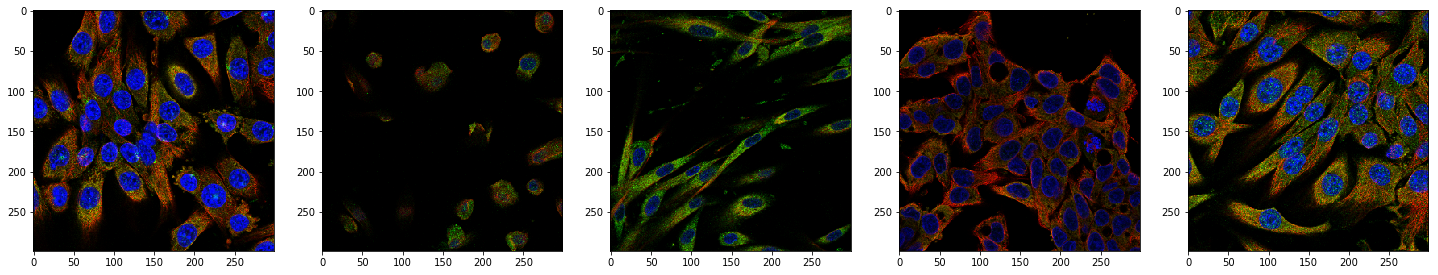

In [10]:
sample = generate_data(5)
images, labels = next(sample)
fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])

## Pretrained models

### Splitting input data into train, validation and test

In [ ]:
sample = generate_data(len(train_dataset_info))
batch_images, batch_labels = next(sample)
X ,y = batch_images,batch_labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [62]:
def create_model_InceptionV3(input_shape,n_out):
    pretrain_model = InceptionV3(include_top=False,
                             weights='imagenet',
                             input_shape=input_shape
                            )
    model = Sequential()
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_out))
    model.add(Activation('softmax'))
    
    return model


# inception_v3
def inception_fine_tune(x_train, y_train,input_shape,n_out):
    inception_model = InceptionV3(weights='imagenet', include_top=False)
    x = inception_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    predictions = Dense(n_out, activation='softmax')(x)

    model = Model(inputs=inception_model.input, outputs=predictions)
    for layer in inception_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    model.fit(x_train, y_train)

    for i, layer in enumerate(model.layers):

        if i < 249:
            layer.trainable = False
        else:
            layer.trainable = True
    return model        


def create_model_CNN(input_shape,n_out):
    model = Sequential()
    model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                             activation ='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten()) 
    model.add(Dropout(0.5))
    # fully connected ANN 
    model.add(Dense(units = 1024, activation = 'relu')) 
    model.add(Dropout(0.5))
    # output layer
    model.add(Dense(units = n_out, activation = 'softmax')) 

    return model

#Model with 3 CNN layers each accompanaied by a Maxpool 2D layer
def create_model_CNN3(input_shape,n_out):
    model = Sequential()
    model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                             activation ='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten()) 
    model.add(Dropout(0.5))

    # fully connected ANN 
    model.add(Dense(units = 1024, activation = 'relu')) 
    model.add(Dropout(0.5))
    # output layer
    #with sigmoid in outer layer, mode is not learning anything
    model.add(Dense(units = n_out, activation = 'softmax')) 
    
    return model


def create_model_gapnet(input_shape,n_out):
    
    dropRate = 0.5
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3))(x)
    x = ReLU()(x)

    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp1 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp1)
    x = Conv2D(64, (3, 3), strides=(2,2))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp2 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp2)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    ginp3 = Dropout(dropRate)(x)
    
    gap1 = GlobalAveragePooling2D()(ginp1)
    gap2 = GlobalAveragePooling2D()(ginp2)
    gap3 = GlobalAveragePooling2D()(ginp3)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(n_out)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [15]:
def plot_accuracy(history):
    plt.plot(history.epoch,history.history['acc'])
    plt.plot(history.epoch,history.history['val_acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('model accuracy')
   
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 
    
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))


    plt.plot(history.epoch, loss, 'b', label='Training')
    plt.plot(history.epoch, val_loss, 'r', label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### 2. InceptionV3

In [33]:
keras.backend.clear_session()

model_inceptionv3 = create_model_InceptionV3(
    input_shape=(299,299,3), 
    n_out=4) #n_out denotes number of labels

model_inceptionv3.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-06),
    metrics=['acc'])

model_inceptionv3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
activation_95 (Activation)   (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              134218752 
_________________________________________________________________
activation_96 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
__________

In [34]:
epochs = 20
# train model
history = model_inceptionv3.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=50)

Train on 1452 samples, validate on 312 samples
Epoch 1/20
1452/1452 [==============================] - 658s 453ms/step - loss: 1.5965 - acc: 0.5620 - val_loss: 1.1047 - val_acc: 0.7147
Epoch 2/20
1452/1452 [==============================] - 641s 441ms/step - loss: 1.3258 - acc: 0.6143 - val_loss: 0.9255 - val_acc: 0.7212
Epoch 3/20
1452/1452 [==============================] - 638s 439ms/step - loss: 1.2202 - acc: 0.6357 - val_loss: 0.8463 - val_acc: 0.7276
Epoch 4/20
1452/1452 [==============================] - 640s 441ms/step - loss: 1.1084 - acc: 0.6185 - val_loss: 0.8254 - val_acc: 0.7308
Epoch 5/20
1452/1452 [==============================] - 638s 440ms/step - loss: 1.0417 - acc: 0.6687 - val_loss: 0.7250 - val_acc: 0.7436
Epoch 6/20
1452/1452 [==============================] - 636s 438ms/step - loss: 0.9596 - acc: 0.6777 - val_loss: 0.7266 - val_acc: 0.7372
Epoch 7/20
1452/1452 [==============================] - 638s 439ms/step - loss: 0.9140 - acc: 0.6963 - val_loss: 0.6671 - val

312/312 [==============================] - 29s 92ms/step
Validation Accuracy: 84.62%
Validation Loss: 0.4242851061698718


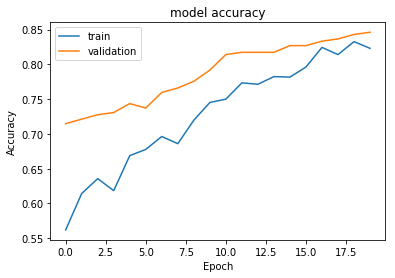

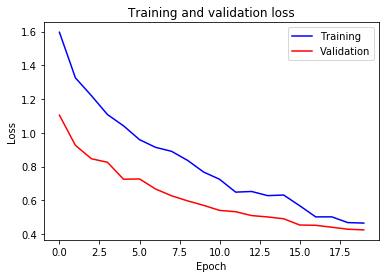

In [35]:
(eval_loss, eval_accuracy) = model_inceptionv3.evaluate(
        x_val,y_val,batch_size=16, verbose=1)

print("Validation Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

plot_accuracy(history)
plot_loss(history)

## InceptionV3 fine tuned

In [63]:
keras.backend.clear_session()

model_inceptionv3_fine_tuned = inception_fine_tune(x_train,y_train,
    input_shape=(299,299,3), 
    n_out=4) #n_out denotes number of labels

model_inceptionv3_fine_tuned.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-06), #Adam optimizer with 0.0001 decay
    metrics=['acc'])

model_inceptionv3_fine_tuned.summary()

Epoch 1/1
1452/1452 [==============================] - 130s 89ms/step - loss: 2.6685
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
________________________

In [64]:
epochs = 20
# train model
history_inception_fine_tuned = model_inceptionv3_fine_tuned.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=50)

Train on 1452 samples, validate on 312 samples
Epoch 1/20
1452/1452 [==============================] - 193s 133ms/step - loss: 1.4478 - acc: 0.7107 - val_loss: 1.4743 - val_acc: 0.7147
Epoch 2/20
1452/1452 [==============================] - 189s 130ms/step - loss: 1.4065 - acc: 0.7107 - val_loss: 1.4462 - val_acc: 0.7147
Epoch 3/20
1452/1452 [==============================] - 189s 130ms/step - loss: 1.3496 - acc: 0.7107 - val_loss: 1.4185 - val_acc: 0.7147
Epoch 4/20
1452/1452 [==============================] - 190s 131ms/step - loss: 1.2927 - acc: 0.7114 - val_loss: 1.3917 - val_acc: 0.7147
Epoch 5/20
1452/1452 [==============================] - 188s 130ms/step - loss: 1.2989 - acc: 0.7114 - val_loss: 1.3654 - val_acc: 0.7147
Epoch 6/20
1452/1452 [==============================] - 189s 130ms/step - loss: 1.2525 - acc: 0.7114 - val_loss: 1.3413 - val_acc: 0.7147
Epoch 7/20
1452/1452 [==============================] - 188s 129ms/step - loss: 1.1882 - acc: 0.7121 - val_loss: 1.3204 - val

312/312 [==============================] - 28s 89ms/step
Validation Accuracy: 71.47%
Validation Loss: 1.0907175647906768


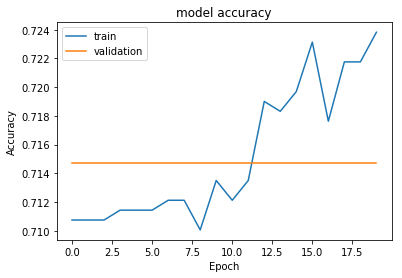

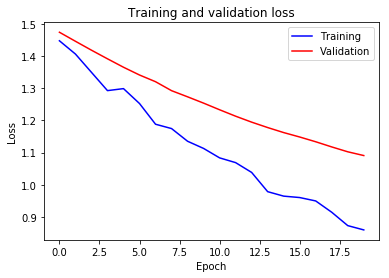

In [65]:
(eval_loss, eval_accuracy) = model_inceptionv3_fine_tuned.evaluate(
        x_val,y_val,batch_size=16, verbose=1)

print("Validation Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

plot_accuracy(history_inception_fine_tuned)
plot_loss(history_inception_fine_tuned)

## CNN from scratch using keras

In [69]:
keras.backend.clear_session()

# train model
model_scratch = create_model_CNN(
    input_shape=(299,299,3), 
    n_out=4)

model_scratch.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-05),
    metrics=['acc'])

model_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 64)      3136      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350464)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 350464)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              358876160 
__________

In [70]:
epochs = 20
history = model_scratch.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val))

Train on 1452 samples, validate on 312 samples
Epoch 1/20
1452/1452 [==============================] - 316s 218ms/step - loss: 0.9852 - acc: 0.7025 - val_loss: 0.8793 - val_acc: 0.7147
Epoch 2/20
1452/1452 [==============================] - 305s 210ms/step - loss: 0.7897 - acc: 0.7190 - val_loss: 0.7485 - val_acc: 0.7212
Epoch 3/20
1452/1452 [==============================] - 307s 212ms/step - loss: 0.6497 - acc: 0.7541 - val_loss: 0.7056 - val_acc: 0.7372
Epoch 4/20
1452/1452 [==============================] - 307s 212ms/step - loss: 0.5601 - acc: 0.7879 - val_loss: 0.6432 - val_acc: 0.7468
Epoch 5/20
1452/1452 [==============================] - 306s 211ms/step - loss: 0.4739 - acc: 0.8285 - val_loss: 0.5764 - val_acc: 0.8013
Epoch 6/20
1452/1452 [==============================] - 307s 211ms/step - loss: 0.4053 - acc: 0.8671 - val_loss: 0.5320 - val_acc: 0.8173
Epoch 7/20
1452/1452 [==============================] - 307s 212ms/step - loss: 0.3343 - acc: 0.8988 - val_loss: 0.4795 - val

311/311 [==============================] - 17s 54ms/step
Test Accuracy: 86.50%
Test Loss: 0.6315417514449148


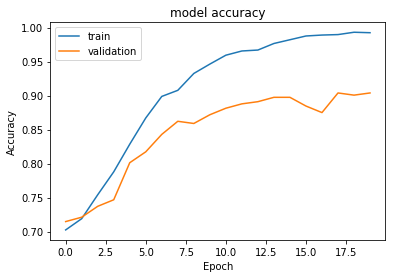

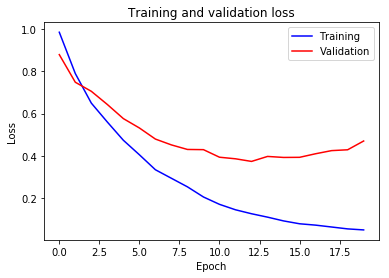

In [75]:
(eval_loss, eval_accuracy) = model_scratch.evaluate(
        x_test,y_test,batch_size=16, verbose=1)

print("Test Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Test Loss: {}".format(eval_loss))

plot_accuracy(history)
plot_loss(history)

312/312 [==============================] - 17s 54ms/step
Validation Accuracy: 90.38%
Validation Loss: 0.47043093695090366


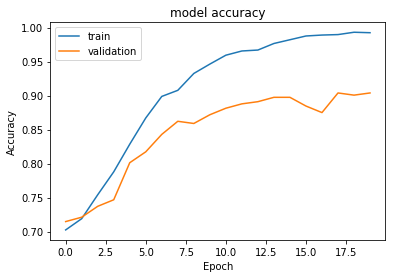

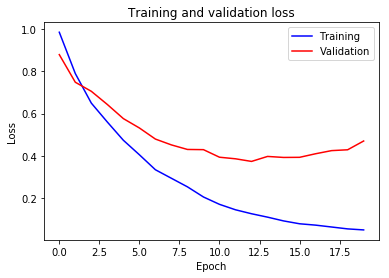

In [76]:
(eval_loss, eval_accuracy) = model_scratch.evaluate(
        x_val,y_val,batch_size=16, verbose=1)

print("Validation Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

plot_accuracy(history)
plot_loss(history)

## Experimentation with different learning rates for SGD optimizer

In [15]:
def diffLearningRates(learningRates):
    accDiffLearRate=[];accDiffLearRateValid=[];lossDiffLearRate=[];lossDiffLearRateValid=[]
    for i in range(len(learningRates)):
        print("Executing for learning rate ",learningRates[i])
        model = create_model_CNN(
            input_shape=(299,299,3), 
            n_out=4)
        model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=learningRates[i],decay=1e-6, momentum=0.9, nesterov=True),metrics=['acc'])
        history=model.fit(x_train,y_train,epochs=10,validation_data=(x_val,y_val))
        accDiffLearRate.append(history.history['acc'])
        accDiffLearRateValid.append(history.history['val_acc'])
        lossDiffLearRate.append(history.history['loss'])
        lossDiffLearRateValid.append(history.history['val_loss'])
    return accDiffLearRate,accDiffLearRateValid,lossDiffLearRate,lossDiffLearRateValid

In [16]:
learningRates=[0.0001,0.001,0.01,0.1]
keras.backend.clear_session()

acc,acc_val,loss,loss_val=diffLearningRates(learningRates)

Executing for learning rate  0.0001
Train on 1452 samples, validate on 312 samples
Epoch 1/10
1452/1452 [==============================] - 282s 194ms/step - loss: 1.0994 - acc: 0.6708 - val_loss: 0.9710 - val_acc: 0.7051
Epoch 2/10
1452/1452 [==============================] - 273s 188ms/step - loss: 0.9174 - acc: 0.7287 - val_loss: 0.9302 - val_acc: 0.7051
Epoch 3/10
1452/1452 [==============================] - 273s 188ms/step - loss: 0.8776 - acc: 0.7287 - val_loss: 0.9077 - val_acc: 0.7051
Epoch 4/10
1452/1452 [==============================] - 274s 189ms/step - loss: 0.8529 - acc: 0.7287 - val_loss: 0.8862 - val_acc: 0.7051
Epoch 5/10
1452/1452 [==============================] - 273s 188ms/step - loss: 0.8331 - acc: 0.7287 - val_loss: 0.8669 - val_acc: 0.7051
Epoch 6/10
1452/1452 [==============================] - 274s 189ms/step - loss: 0.8132 - acc: 0.7287 - val_loss: 0.8481 - val_acc: 0.7051
Epoch 7/10
1452/1452 [==============================] - 271s 187ms/step - loss: 0.7896 - 

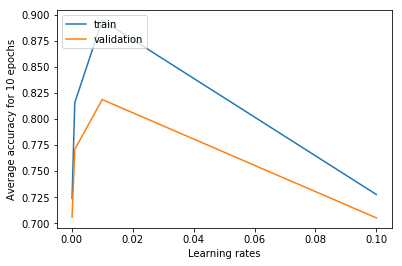

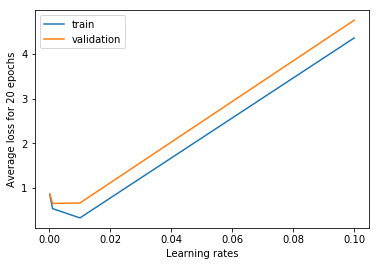

In [22]:
avg_acc=[];avg_acc_val=[];avg_loss=[];avg_loss_val=[]
for i in range(len(acc)):
    avg_acc.append(np.mean(acc[i]))
    avg_acc_val.append(np.mean(acc_val[i]))
    avg_loss.append(np.mean(loss[i]))
    avg_loss_val.append(np.mean(loss_val[i]))


plt.figure(1)
  
plt.xlabel('Learning rates')
plt.ylabel('Average accuracy for 10 epochs')
plt.plot(learningRates,avg_acc)
plt.plot(learningRates,avg_acc_val)
plt.legend(['train', 'validation'], loc='upper left')


plt.figure(2)
plt.xlabel('Learning rates')
plt.ylabel('Average loss for 20 epochs')
plt.plot(learningRates,avg_loss)   
plt.plot(learningRates,avg_loss_val)
plt.legend(['train', 'validation'], loc='upper left')


plt.show()

## CNN from scratch using keras 2

In [11]:
from keras import optimizers

keras.backend.clear_session()

# train model
model_scratch2 = create_model_CNN(
    input_shape=(299,299,3), 
    n_out=4)

#using SGD instead of Adam optimizer
# http://www.insightsbot.com/blog/G1Za1/keras-multi-class-classification-introduction
# Stochastic gradient descent and mini batch of 100 samples
model_scratch2.compile(
    loss='categorical_crossentropy', 
    optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['acc'])

model_scratch2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 64)      3136      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350464)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 350464)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              358876160 
__________

In [12]:
epochs = 20
# https://gist.github.com/Thimira/354b90d59faf8b0d758f74eae3a511e2
history = model_scratch2.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val), batch_size=100)
#predictions = model.predict(x_test)

Train on 1452 samples, validate on 312 samples
Epoch 1/20
1452/1452 [==============================] - 631s 435ms/step - loss: 0.9115 - acc: 0.6915 - val_loss: 0.7634 - val_acc: 0.7436
Epoch 2/20
1452/1452 [==============================] - 448s 308ms/step - loss: 0.7910 - acc: 0.7156 - val_loss: 0.7288 - val_acc: 0.7404
Epoch 3/20
1452/1452 [==============================] - 479s 330ms/step - loss: 0.6973 - acc: 0.7376 - val_loss: 0.6600 - val_acc: 0.7532
Epoch 4/20
1452/1452 [==============================] - 397s 274ms/step - loss: 0.5659 - acc: 0.7817 - val_loss: 0.5759 - val_acc: 0.8141
Epoch 5/20
1452/1452 [==============================] - 521s 359ms/step - loss: 0.5622 - acc: 0.8237 - val_loss: 0.6168 - val_acc: 0.7788
Epoch 6/20
1452/1452 [==============================] - 394s 271ms/step - loss: 0.3804 - acc: 0.8581 - val_loss: 0.5693 - val_acc: 0.8462
Epoch 7/20
1452/1452 [==============================] - 479s 330ms/step - loss: 0.2059 - acc: 0.9229 - val_loss: 0.6898 - val

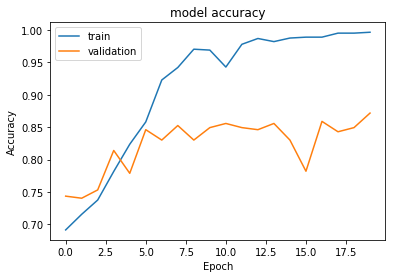

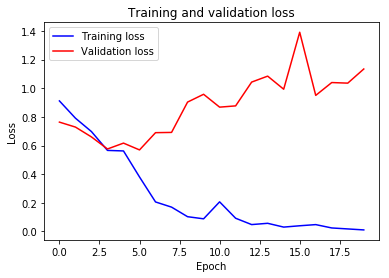

In [25]:
plot_accuracy(history)
plot_loss(history)

## CNN with keras consisting 3 Conv2D layers.

In [12]:
keras.backend.clear_session()

# train model
model_scratch3 = create_model_CNN3(
    input_shape=(299,299,3), 
    n_out=4)

model_scratch3.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc'])

model_scratch3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 299, 299, 64)      3136      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 64)      65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        65600     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)             0         
__________

In [13]:
epochs = 20
history = model_scratch3.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val))
#predictions = model.predict(x_test)

Train on 1452 samples, validate on 312 samples
Epoch 1/20
1452/1452 [==============================] - 277s 190ms/step - loss: 0.8802 - acc: 0.6956 - val_loss: 0.7043 - val_acc: 0.7500
Epoch 2/20
1452/1452 [==============================] - 271s 187ms/step - loss: 0.7332 - acc: 0.7293 - val_loss: 0.6224 - val_acc: 0.7660
Epoch 3/20
1452/1452 [==============================] - 272s 187ms/step - loss: 0.5957 - acc: 0.7700 - val_loss: 0.5629 - val_acc: 0.7756
Epoch 4/20
1452/1452 [==============================] - 273s 188ms/step - loss: 0.4880 - acc: 0.8237 - val_loss: 0.3970 - val_acc: 0.8654
Epoch 5/20
1452/1452 [==============================] - 273s 188ms/step - loss: 0.2780 - acc: 0.9139 - val_loss: 0.3549 - val_acc: 0.8846
Epoch 6/20
1452/1452 [==============================] - 274s 188ms/step - loss: 0.1730 - acc: 0.9456 - val_loss: 0.4196 - val_acc: 0.8878
Epoch 7/20
1452/1452 [==============================] - 274s 189ms/step - loss: 0.1320 - acc: 0.9545 - val_loss: 0.3997 - val

312/312 [==============================] - 17s 54ms/step
Validation Accuracy: 88.46%
Validation Loss: 0.7725140502503237


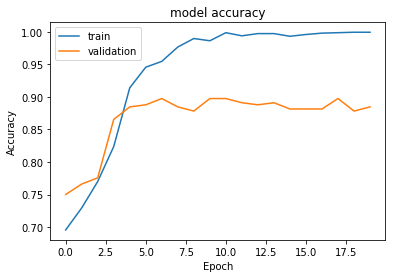

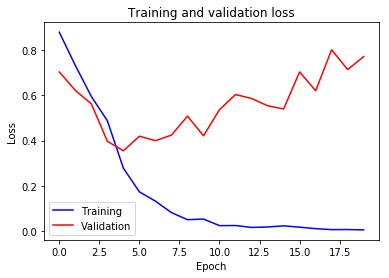

In [16]:
(eval_loss, eval_accuracy) = model_scratch3.evaluate(
        x_val,y_val,batch_size=16, verbose=1)

print("Validation Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

plot_accuracy(history)
plot_loss(history)

## GAPNET

In [14]:
keras.backend.clear_session()

# train model
model_gapnet = create_model_gapnet(
    input_shape=(299,299,3), 
    n_out=4)

model_gapnet.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc'])

model_gapnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 299, 299, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 297, 297, 32) 896         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 297, 297, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [20]:
epochs = 30
# https://gist.github.com/Thimira/354b90d59faf8b0d758f74eae3a511e2
history = model_gapnet.fit(x_train,y_train,epochs=epochs,validation_data=(x_val,y_val),batch_size=50)
#predictions = model.predict(x_test)

Train on 1452 samples, validate on 312 samples
Epoch 1/30
1452/1452 [==============================] - 344s 237ms/step - loss: 1.1231 - acc: 0.5537 - val_loss: 0.8609 - val_acc: 0.7147
Epoch 2/30
1452/1452 [==============================] - 340s 234ms/step - loss: 0.8922 - acc: 0.6894 - val_loss: 0.7981 - val_acc: 0.7468
Epoch 3/30
1452/1452 [==============================] - 339s 234ms/step - loss: 0.8075 - acc: 0.6935 - val_loss: 0.8341 - val_acc: 0.7468
Epoch 4/30
1452/1452 [==============================] - 338s 233ms/step - loss: 0.7587 - acc: 0.7135 - val_loss: 0.7474 - val_acc: 0.7500
Epoch 5/30
1452/1452 [==============================] - 341s 235ms/step - loss: 0.7427 - acc: 0.7266 - val_loss: 0.7448 - val_acc: 0.7564
Epoch 6/30
1452/1452 [==============================] - 339s 234ms/step - loss: 0.7176 - acc: 0.7252 - val_loss: 0.7525 - val_acc: 0.6763
Epoch 7/30
1452/1452 [==============================] - 339s 233ms/step - loss: 0.7151 - acc: 0.7362 - val_loss: 0.7025 - val

In [23]:
(eval_loss, eval_accuracy) = model_gapnet.evaluate(
        x_val,y_val,batch_size=50, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

312/312 [==============================] - 13s 41ms/step
[INFO] accuracy: 75.00%
[INFO] Loss: 0.6547204508231237


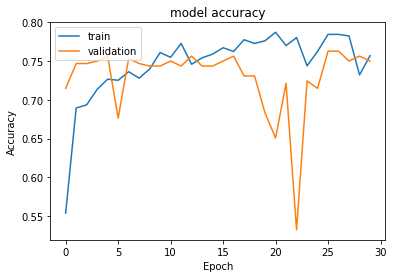

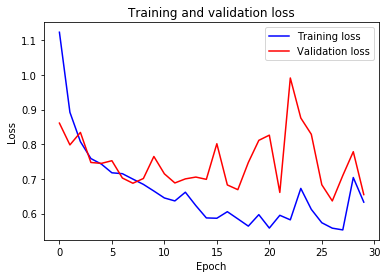

In [35]:
plot_accuracy(history)
plot_loss(history)

## Tuning

In [ ]:
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

model_gapnet_tuned = create_model_gapnet(
    input_shape=(299,299,3), 
    n_out=4)

model_gapnet_tuned.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(1e-04),
    metrics=['acc',f1])

model_gapnet_tuned.summary()

for layer in model_gapnet_tuned.layers:
    layer.trainable = False
for i in range(1,21):    
    model_gapnet_tuned.layers[-i].trainable = True

history_gapnet_tuning = model_gapnet_tuned.fit(x_train,y_train,epochs=50,validation_data=(x_val,y_val),batch_size=50)